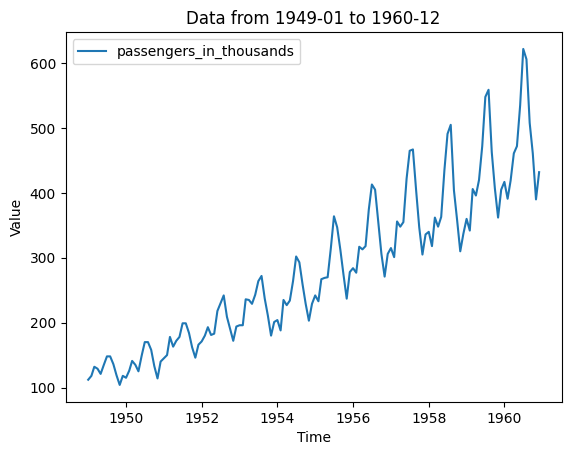

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/airline/airline.csv')

def plot_csv_by_time(csv_path, start_time, end_time):
    # Load CSV file into a pandas dataframe
    df = pd.read_csv(csv_path,parse_dates=['Month'],  index_col=['Month'])
    
    # Select rows within the specified time range
    df = df.loc[start_time:end_time]
    
    # Generate a line plot for each column in the dataframe
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    
    # Set plot title and axis labels
    plt.title(f"Data from {start_time} to {end_time}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    
    # Display legend and show plot
    plt.legend()
    plt.show()


plot_csv_by_time('data/airline/airline.csv', '1949-01', '1960-12')

In [3]:
import torch
import pandas as pd
from src.utils import load_checkpoint
from src.scaler import Scaler
from src.dataset import TimeSeriesDataset
from src.forecast_models import LSTMForecaster
from src.train import train, inference

input_field = ['passengers_in_thousands']
output_field = ['passengers_in_thousands']
timeseries_field = list(set(input_field + output_field))
datasetPath = 'data/airline'
t = 16
h = 4

if torch.cuda.is_available():
    device =  torch.device('cuda')
else:
    device =  torch.device('cpu')

train_df = pd.read_csv(f'{datasetPath}/train.csv')
test_df = pd.read_csv(f'{datasetPath}/test.csv')
val_df = pd.read_csv(f'{datasetPath}/val.csv')
scaler = Scaler(train_df[timeseries_field], 'minmax')

train_dataset = TimeSeriesDataset(train_df, input_field, output_field, t=t, h=h, scaler=scaler)
test_dataset = TimeSeriesDataset(test_df, input_field, output_field, t=t, h=h, scaler=scaler)
val_dataset = TimeSeriesDataset(val_df, input_field, output_field, t=t, h=h, scaler=scaler)

modelPath = 'out/LSTMForecaster_airline/n1_hs128_h4_t16/best.pth.tar'
model = LSTMForecaster(input_size=len(input_field), output_size=len(output_field)*h, hidden_size=128, num_layers=1)
model.to(device)

load_checkpoint(modelPath, model)

criterion = torch.nn.L1Loss()

inference(test_dataset, model, criterion, device=device, batch_size=8)

=> loaded checkpoint 'True' (epoch 861)
Checkpoint's train loss is: 0.2498
Checkpoint's validation loss is: 0.4345


0.43446916341781616

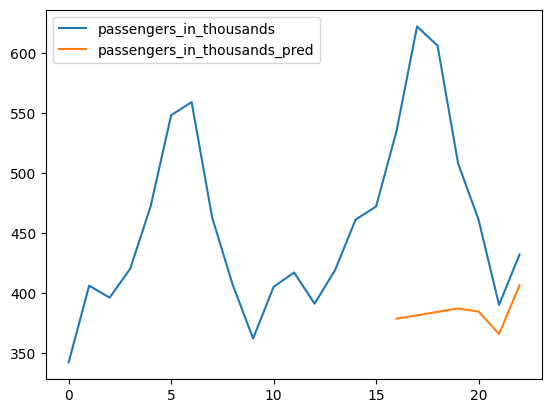

In [4]:
test_dataset.predict(model)
test_dataset.plot_forecast_result()

In [17]:
import pandas as pd
from pmdarima.arima import auto_arima
from src.dataset import TimeSeriesDataset

input_field = ['passengers_in_thousands']
output_field = ['passengers_in_thousands']

train_data = pd.read_csv('data/airline/train.csv', parse_dates=['Month'], index_col=['Month'])
val_data = pd.read_csv('data/airline/val.csv', parse_dates=['Month'], index_col=['Month'])
test_data = pd.read_csv('data/airline/test.csv', parse_dates=['Month'], index_col=['Month'])

train_data = pd.concat([train_data, val_data]) # As this is ARIMA, we dont need validation set

train_dataset = TimeSeriesDataset(train_data, input_field, output_field, scaler=None)
test_dataset = TimeSeriesDataset(test_data, input_field, output_field, scaler=None)

model = auto_arima(train_dataset.data, seasonal=True)  # Adjust the order according to your data
model_fit = model.fit(train_dataset.data)

# Forecasting the future values
forecast = model_fit.predict(n_periods=len(test_dataset.data))

# Printing the forecasted values
print(forecast)

123    445.681201
124    470.218007
125    499.194416
126    525.942843
127    545.149952
128    553.943241
129    552.266248
130    542.542146
131    528.793526
132    515.493795
133    506.454765
134    504.008642
135    508.641019
136    519.105553
137    532.933395
138    547.168056
139    559.124164
140    566.987959
141    570.137368
142    569.140910
143    565.475566
dtype: float64


d:\Projects\TimeSeriesAnalysis\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [1]:
import pandas as pd
from pmdarima.arima import auto_arima

train_data = pd.read_csv('data/airline/train.csv', parse_dates=['Month'], index_col=['Month'])
val_data = pd.read_csv('data/airline/val.csv', parse_dates=['Month'], index_col=['Month'])
test_data = pd.read_csv('data/airline/test.csv', parse_dates=['Month'], index_col=['Month'])

train_data = pd.concat([train_data, val_data]) # As this is ARIMA, we dont need validation set

model = auto_arima(train_data, seasonal=True)  # Adjust the order according to your data
model_fit = model.fit(train_data)

# Forecasting the future values
forecast = model_fit.predict(n_periods=len(test_data))

# Printing the forecasted values
print(forecast)

1959-02-01    374.388368
1959-03-01    393.887361
1959-04-01    413.470157
1959-05-01    428.577171
1959-06-01    436.266031
1959-07-01    435.825631
1959-08-01    428.745429
1959-09-01    418.110774
1959-10-01    407.638670
1959-11-01    400.641763
1959-12-01    399.199176
1960-01-01    403.731441
1960-02-01    413.051658
1960-03-01    424.833112
1960-04-01    436.330231
1960-05-01    445.139186
1960-06-01    449.794880
1960-07-01    450.063718
1960-08-01    446.884995
1960-09-01    442.010491
1960-10-01    437.466107
1960-11-01    434.994032
1960-12-01    435.623582
Freq: MS, dtype: float64
